# Definiëren van hulpfuncties


Importeer libraries:

In [1]:
import numpy as np
from tqdm import tqdm
from numpy import sin, cos
import scipy
from math import log
import math
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time as clock
import asyncio
from matplotlib import animation
from IPython.display import Video
import time as system_time
import seaborn as sns
import os
from scipy.ndimage import gaussian_filter
from matplotlib.colors import LogNorm
from matplotlib.ticker import StrMethodFormatter
import locale

Definieer de constanten / configuratie:

In [2]:
G = 9.81
sns.set_theme()
locale.setlocale(locale.LC_NUMERIC, "de_DE.UTF-8")
plt.rcParams['axes.formatter.use_locale'] = True

Definieer de afgeleiden als een stelsel van 4 differentiaalvergelijkingen van de eerste order:

In [3]:
def derivs(state, t, m1, m2, l1, l2):   
    dydx = np.zeros_like(state)
    dydx[0] = state[1]

    delta = state[2] - state[0]
    den1 = (m1 + m2) * l1 - m2 * l1 * cos(delta) * cos(delta)
    dydx[1] = ((m2 * l1 * state[1] * state[1] * sin(delta) * cos(delta)
                + m2 * G * sin(state[2]) * cos(delta)
                + m2 * l2 * state[3] * state[3] * sin(delta)
                - (m1 + m2) * G * sin(state[0]))
               / den1)

    dydx[2] = state[3]

    den2 = (l2 / l1) * den1
    dydx[3] = ((- m2 * l2 * state[3] * state[3] * sin(delta) * cos(delta)
                + (m1 + m2) * G * sin(state[0]) * cos(delta)
                - (m1 + m2) * l1 * state[1] * state[1] * sin(delta)
                - (m1 + m2) * G * sin(state[2]))
               / den2)
    
    return dydx

Definieer een functie voor het genereren van data vanuit de initiële waarden:

In [4]:
def get_resulting_array(t, theta1, theta1_dot, theta2, theta2_dot, m1, m2, l1, l2):
    state = [theta1, theta1_dot, theta2, theta2_dot]
    
    results = scipy.integrate.odeint(lambda S, t : derivs(S, t, m1, m2, l1, l2), state, t)
    return results

Definieer een functie voor het omzetten van data naar cartesische coördinaten:

In [5]:
def get_coordinates(results, l1, l2):
    theta1 = results[:,0]
    theta2 = results[:,2]
    
    return (
        l1*np.sin(theta1),
        -l1*np.cos(theta1),
        l1*np.sin(theta1) + l2*np.sin(theta2),
        -l1*np.cos(theta1) - l2*np.cos(theta2)
    )

Definieer en functie voor de afstanden tussen twee slingers:

In [6]:
def get_differences(results1, results2):
    return np.abs(np.subtract(results1, results2))

Definieer een functie om de Lyapunov exponenten te berekenen uit twee resultaten:

In [7]:
def get_lyapunov_values(t, differences):
    thetha1_differences = differences[:, 0]
    lyapunov = [0]
    
    for index, time in enumerate(t):
        if (index == 0):
            continue
        exponent = (1 / time) * log(thetha1_differences[index] / thetha1_differences[0])
        lyapunov.append(exponent)
        
    return lyapunov

Maak een class om te helpen bij het loggen van laadtijden:

In [8]:
class TimeLogger:
    def __init__(self, total_frames, name):
        self.total_frames = total_frames
        self.name = name
        self.current_frame = 0
        self.last_result = 0
        self.gain = 0.1
        self.start_time = system_time.time()
        
    def update(self):
        self.current_frame += 1
        
        now = system_time.time()
        dt = now - self.start_time
        self.start_time = now
        
        if (self.last_result == 0):
            self.last_result = dt
                
        filtered_dt = self.gain * dt + (1 - self.gain) * self.last_result
        self.last_result = filtered_dt
            
        frames_remaining = self.total_frames - self.current_frame
        time_remaining = frames_remaining * filtered_dt
        time_remaining_formatted = clock.strftime("%H:%M:%S", clock.gmtime(time_remaining))
        print(str(self.name) + " completion: " + (str(round(self.current_frame / self.total_frames * 1000) / 10)) + "%, time remaining: " + str(time_remaining_formatted), end='\r')

# Genereer data

Poincare doorsnede:

In [11]:
# Configuratie
t_end = 1e4
dt = 1e-3
FPS = 1/dt
t = np.arange(0, t_end, dt)

l1 = 1
l2 = 1
m1 = 1
m2 = 1

def get_section(tolerance, theta1, theta1_dot, theta2, theta2_dot):
    results = get_resulting_array(t, theta1, theta1_dot, theta2, theta2_dot, m1, m2, l1, l2)
    
    theta1 = results[:, 0]
    theta1_dot = results[:, 1]
    theta2 = results[:, 2]
    theta2_dot = results[:, 3]
    
    theta1_good = np.where(np.abs(theta2) < tolerance)
    theta1_dot_good = np.where(theta2_dot + theta1_dot > 0)  
    
    poincare_indices = np.intersect1d(theta1_good, theta1_dot_good)
    poincare_points = np.zeros((len(poincare_indices), 4))

    poincare_points[:, 0] = theta1[poincare_indices]
    poincare_points[:, 1] = theta1_dot[poincare_indices]
    poincare_points[:, 2] = theta2[poincare_indices]
    poincare_points[:, 3] = theta2_dot[poincare_indices]
    return(poincare_points)

plots = 3

theta1_arr = np.linspace(0.1, 0.5, 4)
print(theta1_arr)
total_energy = -10

results = []

for total_energy in tqdm(np.linspace(-15, -6, 4)):
    result_row = []
    for theta1 in theta1_arr:
        theta2 = math.acos((total_energy + m1 * G * l1 * math.cos(theta1)) / (l2 - m2 * G))
        section = get_section(1e-3, theta1, 0, theta2, 0)
        
        result_row.append({
            "theta1": theta1,
            "theta2": theta2,
            "section": section
        })
        
    results.append({
        "energy": total_energy,
        "row": result_row
    })
    
result_dataframe = pd.DataFrame(results)
result_dataframe.to_pickle("data/poincare_section.pkl")

[0.1        0.23333333 0.36666667 0.5       ]


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:01<?, ?it/s]


KeyboardInterrupt: 

Regressie van twee slingers:


In [18]:
# if (os.path.exists("data/regression_pendulums.pkl") or os.path.exists("data/regression_distance.pkl") or os.path.exists("data/regression_lyapunov")):
#     raise UserWarning("Verwijder de bestaande data voordat je nieuwe genreert!")
    
# Configuratie
t_end = 20
dt = 0.02

t = np.arange(0, t_end, dt)

# Slingers configuratie
l1 = 1
l2 = 1
m1 = 1
m2 = 1
theta1 = 0.5 * math.pi
theta2 = 0.5 * math.pi
dtheta = 0.02

# Bereken resulterende data
results1 = get_resulting_array(t, theta1, 0, theta2, 0, m1, m2, l1, l2)
results2 = get_resulting_array(t, theta1 + dtheta, 0, theta2 + dtheta, 0, m1, m2, l1, l2)
distances = get_differences(results1, results2)
lyapunov_values = get_lyapunov_values(t, distances)

# Maak dataframes aan
pendulums_dataframe = pd.DataFrame({"Slinger 1": results1[:, 0], "Slinger 2": results2[:, 0]}, t)
distance_dataframe = pd.DataFrame(distances[:, 0], t)
lyapunov_dataframe = pd.DataFrame(lyapunov_values, t)

# Sla dataframes op
pendulums_dataframe.to_pickle("data/regression_pendulums.pkl")
distance_dataframe.to_pickle("data/regression_distance.pkl")
lyapunov_dataframe.to_pickle("data/regression_lyapunov.pkl")

Lyapunov exponenten bij verschillende massa's:

In [13]:
lyapunov_masses_output_path = "data/lyapunov_masses.pkl"

# if (os.path.exists("data/lyapunov_masses.pkl")):
#     raise UserWarning("Verwijder de bestaande data voordat je nieuwe genreert!")

# Configuratie
t_end = 30
dt = 0.02
FPS = 1/dt
t = np.arange(0, t_end, 1/FPS)

# Slingers configuratie
l1 = 1
l2 = 1
dtheta = 0.02

M_array = np.arange(0.5, 5, 0.5)
theta_array = np.arange(0.1 * math.pi, 0.5 * math.pi, 0.05 * math.pi)
result_matrix = []

timelogger = TimeLogger(len(M_array), "Generating data")

for index, m1 in enumerate(M_array):
    result_row = []
    
    for m2 in M_array:
        lyapunov_sum = 0
        
        for theta in theta_array:
            results1 = get_resulting_array(t, theta - dtheta / 2, 0, theta - dtheta / 2, 0, m1, m2, l1, l2)
            results2 = get_resulting_array(t, theta + dtheta / 2, 0, theta + dtheta / 2, 0, m1, m2, l1, l2)
            distances = get_differences(results1, results2)
            lyapunov_values = get_lyapunov_values(t, distances)

            lyapunov_sum += max(lyapunov_values)
            
        result_row.append(lyapunov_sum / len(theta_array))
    timelogger.update()
        
    result_matrix.append(result_row)

# Maak dataframes aan
result_dataframe = pd.DataFrame(result_matrix, M_array, M_array)

# Sla dataframe op
result_dataframe.to_pickle(lyapunov_masses_output_path)

KeyboardInterrupt: 

Lyapunov exponenten bij verschillende ratios van massas:

In [ ]:
lyapunov_masses_ratios_output_path = "data/lyapunov_masses_ratios.pkl"

# Configuratie
t_end = 30
dt = 0.02
FPS = 1/dt
t = np.arange(0, t_end, 1/FPS)

# Slingers configuratie
l1 = 1
l2 = 1
rM = 5
dtheta = 0.02

M_ratio_array = np.geomspace(0.01, 90, 300)
theta_array = np.arange(0.1 * math.pi, 0.5 * math.pi, 0.05 * math.pi)

timelogger = TimeLogger(len(M_ratio_array) * len(theta_array), "Generating data")

result_row = []  
for index, m_ratio in enumerate(M_ratio_array):
    lyapunov_sum = 0
    
    angle = m_ratio / 360 * math.pi * 2
        
    m1 = math.sin(angle) * rM
    m2 = math.cos(angle) * rM
      
    for theta in theta_array:
        results1 = get_resulting_array(t, theta - dtheta / 2, 0, theta - dtheta / 2, 0, m1, m2, l1, l2)
        results2 = get_resulting_array(t, theta + dtheta / 2, 0, theta + dtheta / 2, 0, m1, m2, l1, l2)
        distances = get_differences(results1, results2)
        lyapunov_values = get_lyapunov_values(t, distances)

        lyapunov_sum += max(lyapunov_values)

        timelogger.update()
            
    result_row.append(lyapunov_sum / len(theta_array))
    
    
dataframe = pd.DataFrame({"ratios": M_ratio_array, "exponents": result_row})
dataframe.to_pickle(lyapunov_masses_ratios_output_path)

Lyapunov exponenten bij verschillende lengtes:

In [ ]:
lyapunov_lengths_output_path = "data/lyapunov_lengths.pkl"

# if (os.path.exists("data/lyapunov_masses.pkl")):
#     raise UserWarning("Verwijder de bestaande data voordat je nieuwe genreert!")

# Configuratie
t_end = 30
dt = 0.02
FPS = 1/dt
t = np.arange(0, t_end, 1/FPS)

# Slingers configuratie
m1 = 1
m2 = 1
dtheta = 0.02

L_array = np.arange(0.5, 30, 0.5)
theta_array = np.linspace(0.1 * math.pi, 0.5 * math.pi, 10)
result_matrix = []

timelogger = TimeLogger(len(L_array), "Generating data")

for index, l1 in enumerate(L_array):
    result_row = []
    
    for l2 in L_array:
        lyapunov_sum = 0
        
        for theta in theta_array:
            results1 = get_resulting_array(t, theta - dtheta / 2, 0, theta - dtheta / 2, 0, m1, m2, l1, l2)
            results2 = get_resulting_array(t, theta + dtheta / 2, 0, theta + dtheta / 2, 0, m1, m2, l1, l2)
            distances = get_differences(results1, results2)
            lyapunov_values = get_lyapunov_values(t, distances)

            lyapunov_sum += max(lyapunov_values)
            
        result_row.append(lyapunov_sum / len(theta_array))
    timelogger.update()
        
    result_matrix.append(result_row)

# Maak dataframes aan
result_dataframe = pd.DataFrame(result_matrix, L_array, L_array)

# Sla dataframe op
result_dataframe.to_pickle(lyapunov_lengths_output_path)

Lyapunov bij verschillende startsnelheden

In [ ]:
if (os.path.exists("data/lyapunov_masses.pkl")):
    raise UserWarning("Verwijder de bestaande data voordat je nieuwe genreert!")

# Configuratie
t_end = 30
dt = 0.02
FPS = 1/dt
t = np.arange(0, t_end, 1/FPS)

# Slingers configuratie
l1 = 1
l2 = 1
m1 = 1
m2 = 1
dtheta = 0.02

theta_dot_array = np.arange(0.5, 4, 0.5)
theta_array = np.linspace(0.1 * math.pi, 0.5 * math.pi, 10)
result_matrix = []

timelogger = TimeLogger(len(theta_dot_array), "Generating data")

for index, theta1_dot in enumerate(theta_dot_array):
    result_row = []
    
    for theta2_dot in theta_dot_array:
        lyapunov_sum = 0
        
        for theta in theta_array:
            results1 = get_resulting_array(t, theta - dtheta / 2, theta1_dot, theta - dtheta / 2, theta2_dot, m1, m2, l1, l2)
            results2 = get_resulting_array(t, theta + dtheta / 2, theta1_dot, theta + dtheta / 2, theta1_dot, m1, m2, l1, l2)
            distances = get_differences(results1, results2)
            lyapunov_values = get_lyapunov_values(t, distances)

            lyapunov_sum += max(lyapunov_values)
            
        result_row.append(lyapunov_sum / len(theta_array))
    timelogger.update()
        
    result_matrix.append(result_row)

# Maak dataframes aan
result_dataframe = pd.DataFrame(result_matrix, theta_dot_array, theta_dot_array)

# Sla dataframe op
result_dataframe.to_pickle("data/lyapunov_velocity.pkl")

Lyapunov Exponent bij verschillende hoeken

In [11]:
# Configuratie
t_end = 30
dt = 0.02
FPS = 1/dt
t = np.arange(0, t_end, 1/FPS)

m1 = 1
m2 = 1
l1 = 1
l2 = 1

theta_array = np.linspace(-math.pi, math.pi, 200)
dtheta = 0.02

# Slingers configuratie
resulting_lyapunovs = []

timelogger = TimeLogger(len(theta_array)**2, "Calculating values")
for theta1 in theta_array:
    row = []
    for theta2 in theta_array:
        results1 = get_resulting_array(t, theta1, 0, theta2, 0, m1, m2, l1, l2)
        results2 = get_resulting_array(t, theta1 + dtheta, 0, theta2 + dtheta, 0, m1, m2, l1, l2)
        distances = get_differences(results1, results2)
        lyapunov_values = get_lyapunov_values(t, distances)
        row.append(max(lyapunov_values))
        timelogger.update()
    resulting_lyapunovs.append(row)

# Maak dataframes aan
result_dataframe = pd.DataFrame(resulting_lyapunovs, theta_array, theta_array)

# Sla dataframe op
result_dataframe.to_pickle("data/lyapunov_angles.pkl")

# Grafieken

In [9]:
params = {"ytick.color" : "w",
          "xtick.color" : "w",
          "axes.labelcolor" : "w",
          "axes.edgecolor" : "w",
          "text.color": "w"
          }
plt.rcParams.update(params)

Poincare doorsnede

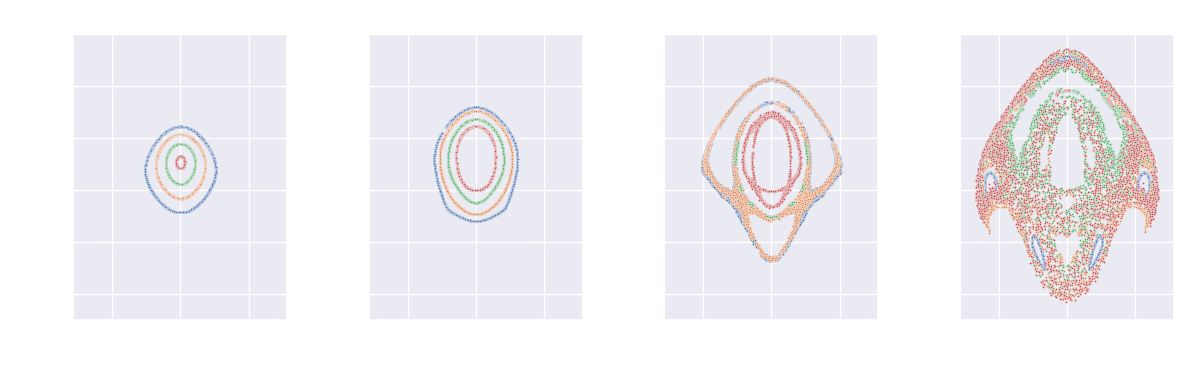

In [23]:
poincare_dataframe = pd.read_pickle("data/poincare_section.pkl")

plots = len(poincare_dataframe)
fig, axs = plt.subplots(1, 4, figsize=(12, 4), gridspec_kw=dict(width_ratios=[4, 4, 4, 4]))

for (i, row) in enumerate(poincare_dataframe.iterrows()):
    potential_energy = row[1]["energy"]
    theta1_data = row[1]["row"]
    for theta1 in theta1_data:
        section = theta1['section']
        axs[i] = sns.scatterplot(x=section[:, 0], y=section[:, 1], alpha=1, marker=".", s=10, ax=axs[i])
        axs[i].set_xlim([-0.5 * math.pi, 0.5 * math.pi])
        axs[i].set_ylim([-5, 6])
        axs[i].set_title(f"$E_p = {str(potential_energy).replace(".", ",")}$ J")
        axs[i].set_ylabel(r"$\dot{\theta}_1$")
        axs[i].set_xlabel(r"$\theta_1$")
        
fig.tight_layout()
plt.savefig("output/poincare.png", transparent=True)

Regressie van twee slingers:

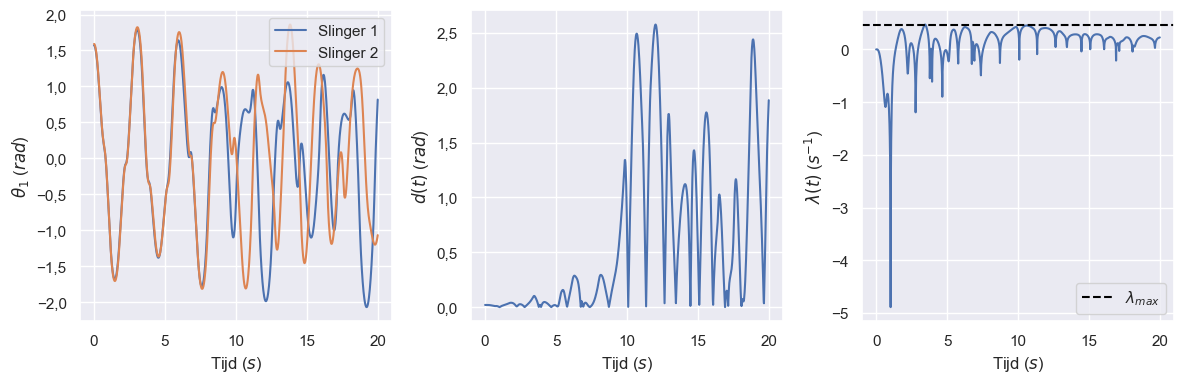

In [19]:

save_name = "output/regression.png"

pendulums_dataframe = pd.read_pickle("data/regression_pendulums.pkl")
distance_dataframe = pd.read_pickle("data/regression_distance.pkl")
lyapunov_dataframe = pd.read_pickle("data/regression_lyapunov.pkl")

# Maak lijnen voor grafiek aan
fig, axs = plt.subplots(1, 3, figsize=(12, 4), gridspec_kw=dict(width_ratios=[4, 4, 4]))

# Figuur 1: Theta2 tegen tijd
plot1 = sns.lineplot(pendulums_dataframe, ax=axs[0], dashes = False)
plot1.set(xlabel=r"Tijd ($s$)", ylabel=r"$\theta_1$ ($rad$)")
sns.move_legend(plot1, "upper right")

plot2 = sns.lineplot(distance_dataframe, ax=axs[1], legend=False)
plot2.set(xlabel=r"Tijd ($s$)", ylabel=r"$d\left(t\right)$ ($rad$)")

plot3 = sns.lineplot(lyapunov_dataframe, ax=axs[2], legend=False)
plot3.set(xlabel=r"Tijd ($s$)", ylabel=r"$\lambda\left(t\right)$ ($s^{-1}$)")

axs[2].axhline(lyapunov_dataframe[0].max(), label=r"$\lambda_{max}$", color="black", linestyle="--")
axs[2].legend()

fig.tight_layout()
plt.savefig(save_name)    

Lyapunov exponenten bij verschillende massa's:

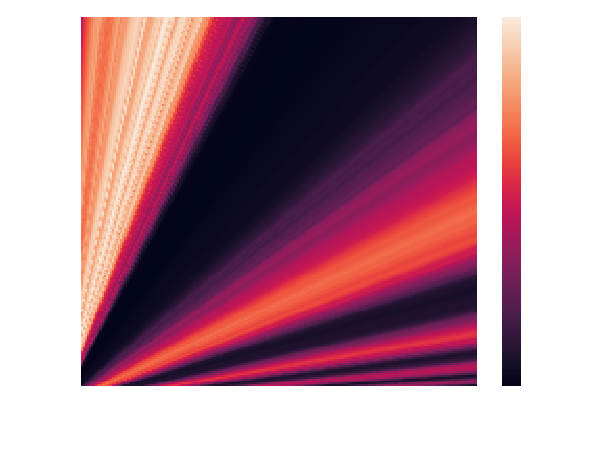

In [14]:
import matplotlib.ticker as ticker
save_name = "output/regression_masses.png"

result_dataframe = pd.read_pickle("data/lyapunov_masses.pkl")

# Maak lijnen voor grafiek aan
fig, ax = plt.subplots(1)
heat_map = sns.heatmap(data=result_dataframe, cbar_kws={'label': r'$\lambda$ ($s^{-1}$)'}, cmap="rocket")
heat_map.invert_yaxis()
heat_map.set(xlabel=r"$m_2$ ($kg$)", ylabel=r"$m_1$ ($kg$)")

N = 1
dTicks = result_dataframe.index[1] - result_dataframe.index[0]

tickLabels = np.arange(result_dataframe.index[0], result_dataframe.index[-1] + N, N).astype(str)
heat_map.set_xticks(np.linspace(0, (len(tickLabels) - 1)/dTicks, len(tickLabels)))
heat_map.set_xticklabels(np.char.replace(tickLabels, ".", ","))

tickLabels = np.arange(result_dataframe.columns[0], result_dataframe.columns[-1] + N, N).astype(str)
heat_map.set_yticks(np.linspace(0, (len(tickLabels) - 1)/dTicks, len(tickLabels)))
heat_map.set_yticklabels(np.char.replace(tickLabels, ".", ","))

plt.savefig(save_name, bbox_inches='tight', transparent=True)

Lyapunov exponenten bij ratio's van massa:

Limit is:  0.09945384097551652 +/- 5.5782838859167956e-05
Higher:  0.09950962381437568  Lower:  0.09939805813665735


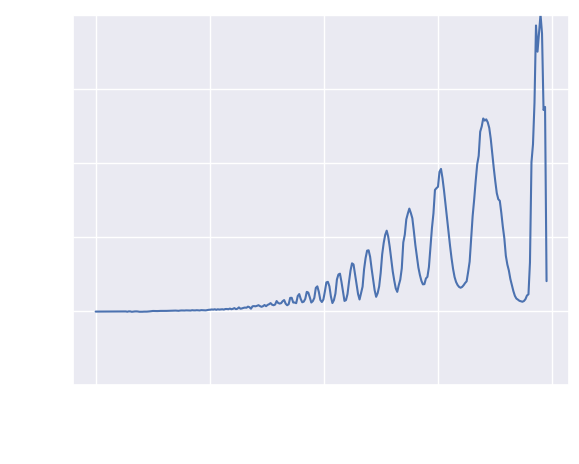

In [11]:
import matplotlib.ticker as ticker
save_name = "output/regression_masses_ratios.png"

result_dataframe = pd.read_pickle("data/lyapunov_masses_ratios.pkl")
    
# Maak lijnen voor grafiek aan
fig, ax = plt.subplots(1)

plot = sns.lineplot(x=result_dataframe["ratios"], y=result_dataframe["exponents"], legend=False)
plot.set(xlabel=r"$\tan^{-1}\left(\frac{m_1}{m_2}\right)$ ($graden$)", ylabel=r"$\lambda$ ($s^{-1}$)")
ax.set_xscale('log')
ax.set_ylim([0, 0.5])   

constantSubset = result_dataframe["exponents"][result_dataframe.index[:50]]
print("Limit is: ", constantSubset.mean(),"+/-", constantSubset.sem())
print("Higher: ", constantSubset.mean() + constantSubset.sem(), " Lower: ", constantSubset.mean() - constantSubset.sem())

plt.savefig(save_name, bbox_inches='tight', transparent=True)

Lyapunov exponenten bij verschillende lengtes:

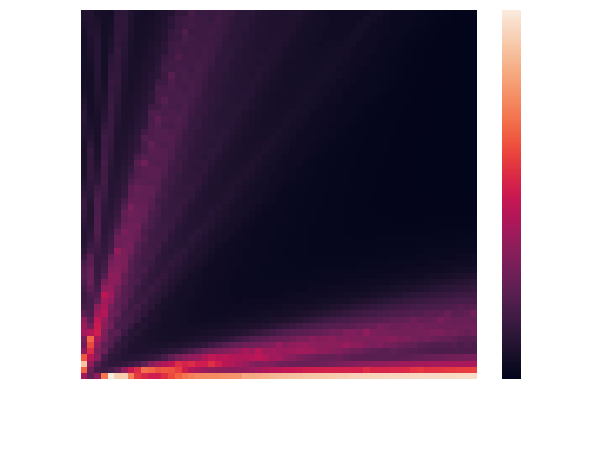

In [15]:
save_name = "output/lyapunov_lengths.png"

result_dataframe = pd.read_pickle("data/lyapunov_lengths.pkl")

# Maak lijnen voor grafiek aan
fig, ax = plt.subplots(1)
heat_map = sns.heatmap(data=result_dataframe, cbar_kws={'label': r'$\lambda$ ($s^{-1}$)'}, cmap="rocket")
heat_map.invert_yaxis()
heat_map.set(xlabel=r"$l_2$ ($kg$)", ylabel=r"$l_1$ ($kg$)")

N = 2
dTicks = (result_dataframe.index[1] - result_dataframe.index[0]) / N

rawTickLabels = np.arange(result_dataframe.index[0] + 0.5, result_dataframe.index[-1], N).astype(str)
    
heat_map.set_xticks(np.linspace(1, (len(rawTickLabels) - 1)/dTicks, len(rawTickLabels)))
heat_map.set_xticklabels(np.char.replace(rawTickLabels, ".", ","))

rawTickLabels = np.arange(result_dataframe.columns[0] + 0.5, result_dataframe.columns[-1], N).astype(str)
heat_map.set_yticks(np.linspace(1, (len(rawTickLabels) - 1)/dTicks, len(rawTickLabels)))
heat_map.set_yticklabels(np.char.replace(rawTickLabels, ".", ","))


plt.savefig(save_name, bbox_inches='tight', transparent=True)

Lyapunov bij verschillende snelheden

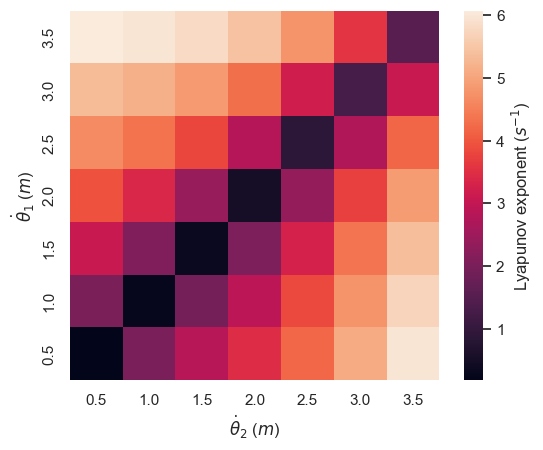

In [44]:
save_name = "output/regression_velocity.png"

result_dataframe = pd.read_pickle("data/lyapunov_velocity.pkl")

# Maak lijnen voor grafiek aan
fig, ax = plt.subplots(1)
ax.set_aspect('equal','box')

heat_map = sns.heatmap(data=result_dataframe, cbar_kws={'label': r'Lyapunov exponent ($s^{-1}$)'})
heat_map.invert_yaxis()
heat_map.set(xlabel=r"$\dot{\theta}_2$ ($m$)", ylabel=r"$\dot{\theta}_1$ ($m$)")

plt.savefig(save_name)

Lyapunov Exponent bij verschillende hoeken

C:\Users\Kevin\AppData\Local\Temp\ipykernel_30044\2277677993.py:3: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


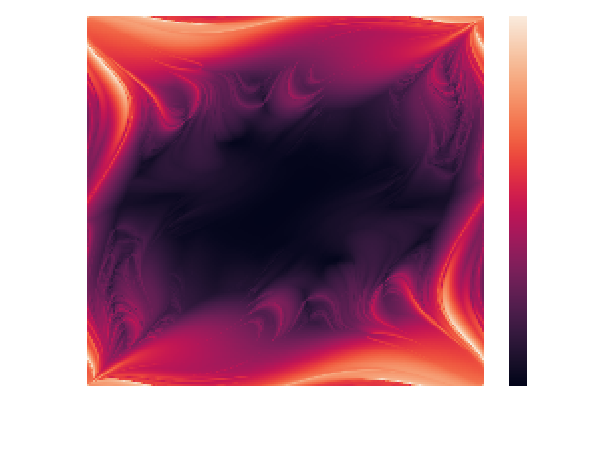

In [16]:
save_name = "output/lyapunov_angles.png"

from scipy.ndimage.filters import gaussian_filter
result_dataframe = pd.read_pickle("data/lyapunov_angles.pkl") 
    
# Maak lijnen voor grafiek aan
fig, ax = plt.subplots(1)

# for i in range(2):
#     result_dataframe = pd.concat([result_dataframe, result_dataframe], axis=0)
#     result_dataframe = pd.concat([result_dataframe, result_dataframe], axis=1)
    
# result_dataframe = gaussian_filter(result_dataframe, sigma=10)

heat_map = sns.heatmap(data=result_dataframe, cbar_kws={'label': r'$\lambda$ ($s^{-1}$)'})
heat_map.invert_yaxis()
heat_map.set(xlabel=r"$\theta_2$ ($rad$)", ylabel=r"$\theta_1$ ($rad$)")



N = math.pi / 5
dTicks = (result_dataframe.index[1] - result_dataframe.index[0]) / N

rawTickLabels = np.arange(result_dataframe.index[0], result_dataframe.index[-1] + N, N)
newTickLabels = [str(item / math.pi).replace(".", ",") + r"$\pi$" for item in rawTickLabels]
    
heat_map.set_xticks(np.linspace(0, (len(newTickLabels) - 1)/dTicks, len(newTickLabels)))
heat_map.set_xticklabels(newTickLabels)

rawTickLabels = np.arange(result_dataframe.columns[0], result_dataframe.columns[-1] + N, N)
newTickLabels = [str(item / math.pi).replace(".", ",") + r"$\pi$" for item in rawTickLabels]
heat_map.set_yticks(np.linspace(0, (len(newTickLabels) - 1)/dTicks, len(newTickLabels)))
heat_map.set_yticklabels(newTickLabels)

# plot = sns.lineplot(x=result_dataframe["theta"], y=result_dataframe["lyapunov"], legend=False)
# plot.set(xlabel=r"$\theta$ ($graden$)", ylabel=r"$\lambda$ ($s^{-1}$)")

# constantSubset = result_dataframe["lyapunov"]
# print("Mean is: ", constantSubset.mean())
# print("Higher: ", constantSubset.mean() + constantSubset.sem(), " Lower: ", constantSubset.mean() - constantSubset.sem())

plt.savefig(save_name, bbox_inches='tight', transparent=True)

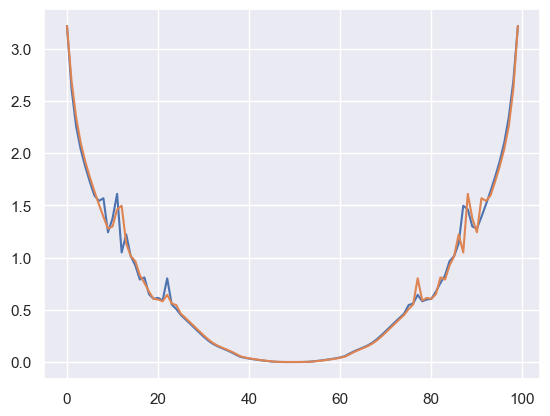

In [41]:
result_dataframe = pd.read_pickle("data/lyapunov_angles_backup.pkl")
    
# Maak lijnen voor grafiek aan
fig, ax = plt.subplots(1)

plt.plot(np.diag(result_dataframe))
plt.plot(np.flip(np.diag(result_dataframe)))

# plot = sns.lineplot(x=result_dataframe["theta"], y=result_dataframe["lyapunov"], legend=False)
# plot.set(xlabel=r"$\theta$ ($graden$)", ylabel=r"$\lambda$ ($s^{-1}$)")

# constantSubset = result_dataframe["lyapunov"]
# print("Mean is: ", constantSubset.mean())
# print("Higher: ", constantSubset.mean() + constantSubset.sem(), " Lower: ", constantSubset.mean() - constantSubset.sem())


In [ ]:
heat_map.set(xlabel=r"$\theta_2$ ($rad$)", ylabel=r"$\theta_1$ ($rad$)")

N = math.pi / 5
dTicks = (result_dataframe.index[1] - result_dataframe.index[0]) / N

rawTickLabels = np.arange(result_dataframe.index[0], result_dataframe.index[-1] + N, N)
newTickLabels = [str(item / math.pi) + r"$\pi$" for item in rawTickLabels]
    
heat_map.set_xticks(np.linspace(0, (len(newTickLabels) - 1)/dTicks, len(newTickLabels)))
heat_map.set_xticklabels(newTickLabels)

rawTickLabels = np.arange(result_dataframe.columns[0], result_dataframe.columns[-1] + N, N)
newTickLabels = [str(item / math.pi) + r"$\pi$" for item in rawTickLabels]
heat_map.set_yticks(np.linspace(0, (len(newTickLabels) - 1)/dTicks, len(newTickLabels)))
heat_map.set_yticklabels(newTickLabels)

# plot = sns.lineplot(x=result_dataframe["theta"], y=result_dataframe["lyapunov"], legend=False)
# plot.set(xlabel=r"$\theta$ ($graden$)", ylabel=r"$\lambda$ ($s^{-1}$)")

# constantSubset = result_dataframe["lyapunov"]
# print("Mean is: ", constantSubset.mean())
# print("Higher: ", constantSubset.mean() + constantSubset.sem(), " Lower: ", constantSubset.mean() - constantSubset.sem())

plt.savefig(save_name, bbox_inches='tight')

Ding voor pepijn

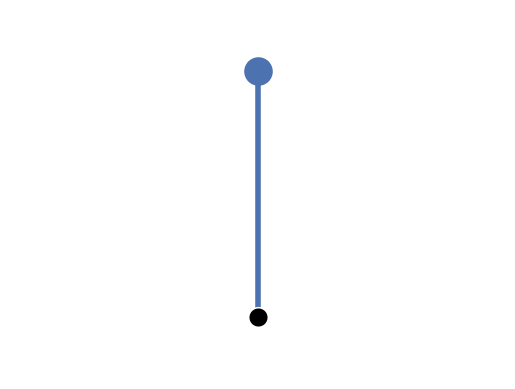

In [51]:
sns.lineplot(x=[0, 0], y=[0, 1], estimator=None, linewidth=4)
sns.scatterplot(x=[0], y=[1], s=500)
sns.scatterplot(x=[0], y=[0], s=200, color="black", zorder=12)
plt.ylim([-0.25, 1.25])
plt.axis('off')
plt.savefig("onePendulum.png", bbox_inches='tight')

# Animaties

Één dubbele slinger:

C:\Users\Kevin\AppData\Local\Temp\ipykernel_24240\2710144031.py:25: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  theta_2_scroller.set_xdata(t[frame])


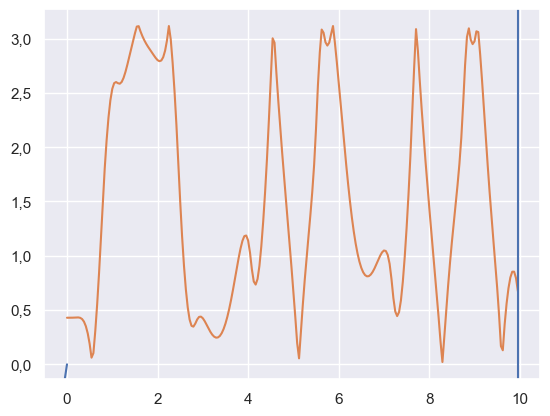

In [28]:
# Configuratie
t_end = 10
FPS = 24
t = np.arange(0, t_end, 1/FPS)

# Slingers configuratie
l1 = 1
l2 = 1
m1 = 1
m2 = 1
theta1 = 2
theta2 = 2

# Bereken resulterende data
results = get_resulting_array(t, theta1, 0, theta2, 0, m1, m2, l1, l2)
x1, y1, x2, y2 = get_coordinates(results, l1, l2)

pendulum_line, = plt.plot([], [])
theta_2_line, = plt.plot(t, np.abs(np.arctan2(np.cos(results[:, 2]), np.sin(results[:, 2]))))
theta_2_scroller = plt.axvline(0)

timelogger = TimeLogger(FPS * t_end, "Animating frames")
def animate(frame):
    pendulum_line.set_data([0, x1[frame], x2[frame]], [0, y1[frame], y2[frame]])
    theta_2_scroller.set_xdata(t[frame])
    timelogger.update()
    
ani = animation.FuncAnimation(fig, animate, frames=len(results), interval=1000/FPS)
ani.save("output/single_pendulum.mp4")
Video("output/single_pendulum.mp4")

Regressie van twee slingers

C:\Users\Kevin\AppData\Local\Temp\ipykernel_29288\2060267216.py:60: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  distance_time_scroller.set_xdata(frame / FPS)
C:\Users\Kevin\AppData\Local\Temp\ipykernel_29288\2060267216.py:61: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  lyapunov_time_scroller.set_xdata(frame / FPS)


KeyboardInterrupt: 

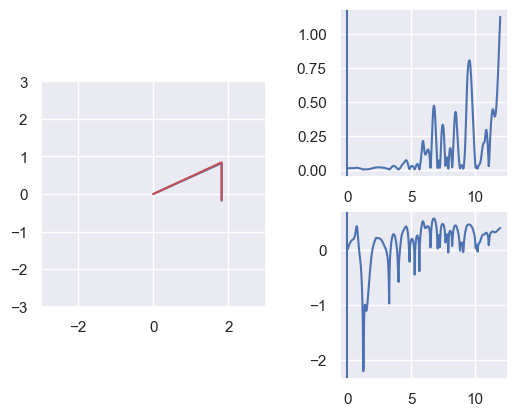

In [16]:
# Animatie configuratie
t_end = 12
FPS = 30
t = np.arange(0, t_end, 1/FPS)
trace_time = 1
save_name = "output/regression.mp4"

# Slingers configuratie
l1 = 2
l2 = 1
m1 = 2
m2 = 1
theta1 = 2
theta2 = 0
dtheta = 0.01

# Bereken resulterende data
results1 = get_resulting_array(t, theta1 - dtheta / 2, 0, theta2 - dtheta / 2, 0, m1, m2, l1, l2)
results2 = get_resulting_array(t, theta1 + dtheta / 2, 0, theta2 + dtheta / 2, 0, m1, m2, l1, l2)
x1_1, y1_1, x2_1, y2_1 = get_coordinates(results1, l1, l2)
x1_2, y1_2, x2_2, y2_2 = get_coordinates(results2, l1, l2)

distances = get_differences(results1, results2)
lyapunov_values = get_lyapunov_values(t, distances)

# Maak lijnen voor grafiek aan
fig = plt.figure()
ax1 = plt.subplot(2, 2, (1, 3))
ax2 = plt.subplot(2, 2, 2)
ax3 = plt.subplot(2, 2, 4, sharex=ax2)
ax1.set_box_aspect(1)
ax2.set_box_aspect(1)
ax3.set_box_aspect(1)
ax1.set_xlim(-3, 3)
ax1.set_ylim(-3, 3)

pendulum_line1, = ax1.plot([], [], color="b")
pendulum_line2, = ax1.plot([], [], color="r")
pendulum_trace_line1, = ax1.plot([], [], color="b", alpha=0.2)
pendulum_trace_line2, = ax1.plot([], [], color="r", alpha=0.2)

distance_line = ax2.plot(t, distances[:, 0])
distance_time_scroller = ax2.axvline(0)

lyapunov_line, = ax3.plot(t, lyapunov_values)
lyapunov_time_scroller = ax3.axvline(0)

timeLogger = TimeLogger(len(t), "Frame animation")

# Definieer de animatie functie
def animate(frame):
    trace_start_frame = np.clip(frame - trace_time * FPS, 0, len(t))
    
    pendulum_line1.set_data([0, x1_1[frame], x2_1[frame]], [0, y1_1[frame], y2_1[frame]])
    pendulum_line2.set_data([0, x1_2[frame], x2_2[frame]], [0, y1_2[frame], y2_2[frame]])
    
    pendulum_trace_line1.set_data(x2_1[trace_start_frame:frame], y2_1[trace_start_frame:frame])
    pendulum_trace_line2.set_data(x2_2[trace_start_frame:frame], y2_2[trace_start_frame:frame])
        
    distance_time_scroller.set_xdata(frame / FPS)
    lyapunov_time_scroller.set_xdata(frame / FPS)
    
    timeLogger.update()

# Maak een animatie, sla hem op en laat hem zien
ani = animation.FuncAnimation(fig, animate, frames=len(t), interval=1000/FPS)
ani.save(save_name)
Video(save_name)

Regressie van vele slingers

In [75]:
# Animatie configuratie
t_end = 20
FPS = 30
t = np.arange(0, t_end, 1/FPS)
trace_time = 1
save_name = "output/regression.mp4"

sns.reset_orig()

# Slingers configuratie
l1 = 2
l2 = 1
m1 = 2
m2 = 1
theta1 = 2
theta2 = 2
N = 100
theta_range = 1e-2

coordinates = []
pendulum_lines = []
pendulum_points = []

fig = plt.figure()

colormap = plt.cm.viridis #nipy_spectral, Set1,Paired   
colors = [colormap(i) for i in np.linspace(0, 1, N)]


for i in range(N):
    pendulum_line, = plt.plot([], [], color=colors[i], zorder=i)
    pendlum_point = plt.scatter([], [], color=colors[i], zorder=i)

    x1, y1, x2, y2 = get_coordinates(get_resulting_array(t, theta1 + theta_range / N * i, 0, theta2 + theta_range / N * i, 0, m1, m2, l1, l2), l1, l2)
    coordinates.append([x1, y1, x2, y2])
    pendulum_lines.append(pendulum_line)
    pendulum_points.append(pendlum_point)
    

pivot_point = plt.scatter([0], [0], color="black", zorder=N+2)
timeLogger = TimeLogger(len(t), "Frame animation")
def animate(frame):
    pivot_point.set_offsets([[0, 0]])
    
    for i in range(N):
        pendulum_line = pendulum_lines[i]
        pendlum_point = pendulum_points[i]
        x1, y1, x2, y2 = coordinates[i]
        
        pendulum_line.set_data([0, x1[frame], x2[frame]], [0, y1[frame], y2[frame]])
        pendlum_point.set_offsets([[x1[frame], y1[frame]], [x2[frame], y2[frame]]])
    
    timeLogger.update()


plt.ylim([-4, 3])
plt.xlim([-4, 4])
plt.axis('off')
# Maak een animatie, sla hem op en laat hem zien
ani = animation.FuncAnimation(fig, animate, frames=len(t), interval=1000/FPS)
ani.save(save_name)
Video(save_name)